# Pandas Best Practices
## 5 Tips for Better Pandas Code

In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import pyarrow

import io
import zipfile
#import modin.pandas as pd

In [2]:
%%time
gss = pd.read_csv('GSS.csv', index_col=0, dtype_backend='pyarrow', engine='pyarrow')

CPU times: user 44.1 ms, sys: 20.8 ms, total: 64.9 ms
Wall time: 156 ms


In [6]:
# a glorious function
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
    )

tweak_gss(gss)

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


4

## About Matt  Harrison @\_\_mharrison\_\_

* Author of Effective Pandas, Machine Learning Pocket Reference, and Illustrated Guide to Python 3.
* Advisor at Ponder (creators of Modin)
* Corporate trainer at MetaSnake. Taught Pandas to 1000's of students.
* Use coupon LIVE for 10% off Effective Pandas book or bundle ( https://store.metasnake.com )

## Practice this on your data with your team!
* Contact me matt@metasnake.com
* Follow on Twitter @\_\_mharrison\_\_

## Outline

* Load Data
* Types
* Chaining
* Mutation
* Apply
* Aggregation

## Data

In [2]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import pyarrow

import io
import zipfile
#import modin.pandas as pd

In [3]:
pd.__version__

'2.1.1'

In [4]:
pyarrow.__version__

'13.0.0'

In [ ]:
# https://gss.norc.org/get-the-data/stata
# takes a few minutes on my computer to load
path = '/mnt/c/Users/matt/Downloads/gss_spss_with_codebook.zip'
with zipfile.ZipFile(path) as z:
    print(z.namelist())
    with open('gss.sav', mode='bw') as fout:
        fout.write(z.open('GSS7218_R3.sav').read())
    gss = pd.read_spss('gss.sav')

In [ ]:
!pip install pyreadstat

In [ ]:
%%time
import pyreadstat
gss, meta = pyreadstat.read_sav('gss.sav')

In [ ]:
gss.shape

In [ ]:
gss.to_feather('gss.fth')

In [ ]:
%%time
raw = pd.read_feather('~/Dropbox/work/jupyter/gss.fth')

In [ ]:
raw

In [ ]:
# 6000 columns!
raw.shape

In [ ]:
cols = ['YEAR','ID','AGE', 'HRS1','OCC','MAJOR1','SEX','RACE','BORN','INCOME',
        'INCOME06','HONEST','TICKET']

raw[cols].to_feather('honest.fth')

## Loading Data

In [5]:
raw = pd.read_feather('honest.fth', dtype_backend='pyarrow')

## My Cleanup
See GSS_Codebook.pdf for explanation

Columns:

* YEAR
* ID - RESPONDENT ID NUMBER
* AGE - AGE OF RESPONENT
* HRS1 - NUMBER OF HOURS WORKED LAST WEEK
* OCC - R'S CENSUS OCCUPATION CODE (1970) - Page 126 (VAR: OCC) see page 125 for notes APPENDIX F,G,H
   Appendix F - Page 3286
* MAJOR1 - COLLEGE MAJOR 1
* SEX - RESPONDENTS SEX
* RACE - RACE OF RESPONDENT
* BORN -  WAS R BORN IN THIS COUNTRY
* INCOME - TOTAL FAMILY INCOME 1970
* INCOME06 - TOTAL FAMILY INCOME 2006
* HONEST - HONEST
* TICKET - EVER RECEIVED A TRAFFIC TICKET


In [ ]:
cols = ['YEAR','ID','AGE', 'HRS1','OCC','MAJOR1','SEX','RACE','BORN','INCOME',
        'INCOME06','HONEST','TICKET']

raw[cols].isna().mean()*100

In [ ]:
(raw
 [cols]
 .isna()
 .mean()*100
)

In [ ]:
MAJOR= '''RESPONSE PUNCH 1972-82 1982B 1983-87 1987B 1988-91 1993-98 2000-04 2006 2008 2010 2012 2014 2016 2018 ALL
Accounting/bookkeeping 1 0 0 0 0 0 0 0 0 0 0 28 32 30 29 119
Advertising 2 0 0 0 0 0 0 0 0 0 0 3 2 0 0 5
Agriculture/horticulture 3 0 0 0 0 0 0 0 0 0 0 8 2 7 5 22
Allied health 4 0 0 0 0 0 0 0 0 0 0 0 2 1 0 3
Anthropology 5 0 0 0 0 0 0 0 0 0 0 3 5 1 1 10
Architecture 6 0 0 0 0 0 0 0 0 0 0 2 3 5 3 13
Art 7 0 0 0 0 0 0 0 0 0 0 6 7 11 10 34
Biology 8 0 0 0 0 0 0 0 0 0 0 16 22 33 26 97
Business administration 9 0 0 0 0 0 0 0 0 0 0 90 142 172 138 542
Chemistry 11 0 0 0 0 0 0 0 0 0 0 5 8 10 4 27
Communications/speech 12 0 0 0 0 0 0 0 0 0 0 20 18 26 18 82
Comm. disorders 13 0 0 0 0 0 0 0 0 0 0 4 6 2 2 14
Computer science 14 0 0 0 0 0 0 0 0 0 0 25 24 33 17 99
Dentistry 15 0 0 0 0 0 0 0 0 0 0 2 4 3 5 14
Education 16 0 0 0 0 0 0 0 0 0 0 73 91 97 79 340
Economics 17 0 0 0 0 0 0 0 0 0 0 11 19 13 19 62
Engineering 18 0 0 0 0 0 0 0 0 0 0 47 49 47 54 197
English 19 0 0 0 0 0 0 0 0 0 0 23 26 27 24 100
Finance 20 0 0 0 0 0 0 0 0 0 0 7 15 14 16 52
Foreign language 21 0 0 0 0 0 0 0 0 0 0 4 8 6 5 23
Forestry 22 0 0 0 0 0 0 0 0 0 0 1 0 3 0 4
Geography 23 0 0 0 0 0 0 0 0 0 0 0 2 2 4 8
Geology 24 0 0 0 0 0 0 0 0 0 0 1 3 4 2 10
History 25 0 0 0 0 0 0 0 0 0 0 10 19 14 19 62
Home economics 26 0 0 0 0 0 0 0 0 0 0 0 0 3 2 5
Industry & techn 27 0 0 0 0 0 0 0 0 0 0 3 4 6 0 13
Journalism 28 0 0 0 0 0 0 0 0 0 0 5 6 6 4 21
Law 29 0 0 0 0 0 0 0 0 0 0 13 18 23 14 68
Law enforcement 30 0 0 0 0 0 0 0 0 0 0 3 5 4 2 14
Library science 31 0 0 0 0 0 0 0 0 0 0 4 5 2 3 14
Marketing 32 0 0 0 0 0 0 0 0 0 0 11 15 13 12 51
Mathematics 33 0 0 0 0 0 0 0 0 0 0 5 10 12 5 32
Medicine 34 0 0 0 0 0 0 0 0 0 0 9 25 12 11 57
Music 35 0 0 0 0 0 0 0 0 0 0 4 2 10 2 18
Nursing 36 0 0 0 0 0 0 0 0 0 0 36 39 60 51 186
Optometry 37 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Pharmacy 38 0 0 0 0 0 0 0 0 0 0 2 5 4 4 15
Philosophy 39 0 0 0 0 0 0 0 0 0 0 2 0 2 2 6
Physical education 40 0 0 0 0 0 0 0 0 0 0 9 6 16 6 37
Physics 41 0 0 0 0 0 0 0 0 0 0 3 6 7 4 20
Psychology 42 0 0 0 0 0 0 0 0 0 0 32 32 34 29 127
Political science/international relations 43 0 0 0 0 0 0 0 0 0 0 16 22 19 14 71
Sociology 44 0 0 0 0 0 0 0 0 0 0 9 15 10 12 46
Special education 45 0 0 0 0 0 0 0 0 0 0 5 3 5 2 15
Theater arts 46 0 0 0 0 0 0 0 0 0 0 6 2 3 1 12
Theology 47 0 0 0 0 0 0 0 0 0 0 6 6 13 8 33
Veterinary medicine 48 0 0 0 0 0 0 0 0 0 0 1 5 3 4 13
Liberal arts 49 0 0 0 0 0 0 0 0 0 0 8 16 12 10 46
Other 50 0 0 0 0 0 0 0 0 0 0 8 10 21 27 66
General sciences 51 0 0 0 0 0 0 0 0 0 0 10 13 15 14 52
Social work 52 0 0 0 0 0 0 0 0 0 0 7 17 24 7 55
General studies 53 0 0 0 0 0 0 0 0 0 0 2 5 7 7 21
Other vocational 54 0 0 0 0 0 0 0 0 0 0 5 11 6 5 27
Health 55 0 0 0 0 0 0 0 0 0 0 23 31 31 42 127
Industrial Relations 56 0 0 0 0 0 0 0 0 0 0 1 0 0 3 4
Child/Human/Family Development 57 0 0 0 0 0 0 0 0 0 0 11 3 7 7 28
Food Science/Nutrition/Culinary Arts 58 0 0 0 0 0 0 0 0 0 0 3 6 9 9 27
Environmental Science/Ecology 59 0 0 0 0 0 0 0 0 0 0 5 5 6 8 24
Social Sciences 60 0 0 0 0 0 0 0 0 0 0 4 2 7 5 18
Human Services/Human Resources 61 0 0 0 0 0 0 0 0 0 0 3 7 7 5 22
Visual Arts/Graphic Design/Design and Drafting 62 0 0 0 0 0 0 0 0 0 0 3 8 9 10 30
Fine Arts 63 0 0 0 0 0 0 0 0 0 0 4 5 5 6 20
Humanities 64 0 0 0 0 0 0 0 0 0 0 0 2 0 1 3
Ethnic studies 65 0 0 0 0 0 0 0 0 0 0 3 1 0 0 4
Educational administration 66 0 0 0 0 0 0 0 0 0 0 3 4 8 9 24
Television/Film 67 0 0 0 0 0 0 0 0 0 0 0 2 6 1 9
Aviation/Aeronatics 68 0 0 0 0 0 0 0 0 0 0 2 1 1 3 7
Statistics/Biostatistics 69 0 0 0 0 0 0 0 0 0 0 0 0 2 2 4
Criminology/Criminal Justice 70 0 0 0 0 0 0 0 0 0 0 13 17 17 13 60
Administrative Science/Public Administration 71 0 0 0 0 0 0 0 0 0 0 2 11 3 5 21
Electronics 72 0 0 0 0 0 0 0 0 0 0 6 6 5 9 26
Urban and Regional Planning 73 0 0 0 0 0 0 0 0 0 0 1 1 3 2 7
Mechanics/Machine Trade 74 0 0 0 0 0 0 0 0 0 0 0 1 1 4 6
Dance 75 0 0 0 0 0 0 0 0 0 0 1 0 1 1 3
Gerontology 76 0 0 0 0 0 0 0 0 0 0 1 0 1 1 3
Public Relations 77 0 0 0 0 0 0 0 0 0 0 3 1 2 1 7
Textiles/Cloth 78 0 0 0 0 0 0 0 0 0 0 3 4 0 0 7
Parks and Recreation 79 0 0 0 0 0 0 0 0 0 0 1 2 1 0 4
Information Technology 80 0 0 0 0 0 0 0 0 0 0 0 5 8 11 24
Fashion 81 0 0 0 0 0 0 0 0 0 0 0 0 3 1 4
Counseling 82 0 0 0 0 0 0 0 0 0 0 0 0 11 9 20
Don't know/UNCODED 98 0 0 0 0 0 0 0 0 0 0 2 3 0 0 5
No answer 99 0 0 0 0 0 0 0 0 0 0 0 1 5 3 9
Not applicable 0 13626 354 7542 353 5907 10334 8394 4510 2023 2044 1263 1597 1795 1435 61177'''

# copy paste slight tweak from page 186
major_dict = {int(row.split()[-16]): ' '.join(row.split()[:-16])  for row in MAJOR.split('\n')[1:]}
major_dict

In [ ]:
raw.MAJOR1.value_counts()

In [ ]:
(raw
 [cols]
 .assign(
     MAJOR1=raw.MAJOR1.fillna(99).astype('int').replace(major_dict),
     SEX=raw.SEX#
           .astype(int)
           .replace({1:'Male', 2:'Female'}),
     RACE=raw.RACE.astype(int).replace({1:'White', 2:'Black', 3:'Other'}),
     OCC=raw.OCC.fillna(9999).astype(int),
     BORN=raw.BORN.fillna(4).astype(int).replace({1:'Yes', 2:'No', 3:'Don\'t Know',
                                                    4:'No answer', 5:'Not applicable'}),
     INCOME=raw.INCOME.fillna(99).astype(int).replace({99:'No answer', **dict(enumerate(['Not applicable',
                                                                                  0,1000,3000,4000,5000,6000,
                                                                                  7000,8000,10000,15000,20000,25000,]))}),
     INCOME06=raw.INCOME06.fillna(26).astype(int).replace({26:'Refused', **dict(enumerate(['Not applicable',
                                                                                  0,1000,3000,4000,5000,6000,
                                                                                  7000,8000,10000,12500,15000,
                                                                                  17500,20000,22500,25000,30_000,
                                                                                  35_000, 40_000, 50_000, 60_000,
                                                                                 75_000, 90_000, 110_000, 130_000,
                                                                                 150_000]))}),
     HONEST=raw.HONEST.fillna(9).astype(int).replace({1:'Most desirable', 2:'3 most desireable',
                                                                   3:'Not mentioned', 4:  '3 least desireable',
                                                                   5: 'One least desireable',
                                                                    9:'No answer'}),
     TICKET=raw.TICKET.fillna(9).astype(int).replace({1:'Yes', 2:'No', 3:'Refused', 9: 'No answer'}),
     )
 .astype({'YEAR':int, 'ID': 'uint16[pyarrow]'})
 .to_csv('GSS.csv')
)

## Types
Getting the right types will enable analysis and correctness.


In [6]:
%%time
gss = pd.read_csv('GSS.csv', index_col=0, dtype_backend='pyarrow', engine='pyarrow')

CPU times: user 55.4 ms, sys: 4.38 ms, total: 59.8 ms
Wall time: 55.5 ms


In [7]:
print(len(dir(pd)))

141


In [ ]:
pd.read

In [8]:
gss.dtypes

YEAR         int64[pyarrow]
ID           int64[pyarrow]
AGE         double[pyarrow]
HRS1        double[pyarrow]
OCC          int64[pyarrow]
MAJOR1      string[pyarrow]
SEX         string[pyarrow]
RACE        string[pyarrow]
BORN        string[pyarrow]
INCOME      string[pyarrow]
INCOME06    string[pyarrow]
HONEST      string[pyarrow]
TICKET      string[pyarrow]
dtype: object

In [26]:
gss

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23.0,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48.0,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27.0,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61.0,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37.0,36.0,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75.0,36.0,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67.0,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [20]:
gss.memory_usage(deep=True)

Index       2632088
YEAR         518512
ID           518512
AGE          526616
HRS1         526616
OCC          518512
MAJOR1       863001
SEX          590912
RACE         583326
BORN         504166
INCOME       603690
INCOME06     689894
HONEST       888283
TICKET       760844
dtype: int64

In [21]:
# 36 M (pandas 1)
# 10.7 M (Pandas 2)
gss.memory_usage(deep=True).sum()

10724972

## Ints

In [24]:
gss.select_dtypes(int).describe()

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [32]:
gss.shape

(64814, 13)

In [31]:
# chaining
(gss
 .select_dtypes(int)
 .describe()
 )

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [37]:
# can comb08 be an int8?
# Do completion on int
np.iinfo(np.int16)

iinfo(min=-32768, max=32767, dtype=int16)

In [38]:
np.iinfo(np.uint8)

iinfo(min=0, max=255, dtype=uint8)

In [39]:
np.iinfo(np.uint16)

iinfo(min=0, max=65535, dtype=uint16)

In [43]:
len(dir(gss.YEAR))

418

In [47]:
pd.Series.mean?

Signature:
pd.Series.mean(
    self,
    axis: 'Axis | None' = 0,
    skipna: 'bool' = True,
    numeric_only: 'bool' = False,
    **kwargs,
)
Docstring:
Return the mean of the values over the requested axis.

Parameters
----------
axis : {index (0)}
    Axis for the function to be applied on.
    For `Series` this parameter is unused and defaults to 0.

    For DataFrames, specifying ``axis=None`` will apply the aggregation
    across both axes.

    .. versionadded:: 2.0.0

skipna : bool, default True
    Exclude NA/null values when computing the result.
numeric_only : bool, default False
    Include only float, int, boolean columns. Not implemented for Series.

**kwargs
    Additional keyword arguments to be passed to the function.

Returns
-------
scalar or scalar

            Examples
            --------
            >>> s = pd.Series([1, 2, 3])
            >>> s.mean()
            2.0

            With a DataFrame

            >>> df = pd.DataFrame({'a': [1, 2], 'b': [2, 3]}, ind

In [48]:
pd.Series([20, None, 40], dtype='int8[pyarrow]').mean(skipna=False)

<NA>

In [50]:
# chaining
(gss
 .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]' })
 .select_dtypes(['uint16'])
 .describe()
)

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [53]:
# chaining
# use 'integer' so see all int-like columns
(gss
 .astype({#'YEAR': 'uint16[pyarrow]',
          'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]' }) 
 .select_dtypes(['integer'])  # see https://numpy.org/doc/stable/reference/arrays.scalars.html
 .describe()
)

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [54]:
# Inspect memory usage
(gss
 .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]' }) 
 .memory_usage(deep=True)
 .sum()  # was 36M
)

9582626

## Int Exercise
* Try converting *YEAR* to `'int8'`. What do the values look like?
* Try converting *YEAR* to `'int8[pyarrow]'`. What do the values look like?

In [57]:
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

In [59]:
(gss
 .astype({'YEAR': 'int8[pyarrow]'})
# .describe()
 )

ArrowInvalid: Integer value 1972 not in range: -128 to 127: Error while type casting for column 'YEAR'

In [ ]:
(gss
 .astype({'YEAR': 'int8'})
 .describe()
 )

,YEAR,ID,AGE,HRS1,OCC
count,64814.000000,64814.000000,64586.000000,37506.000000,64814.000000
mean,-53.060820,1151.810211,46.099356,41.303711,6418.583284
std,13.465368,828.030233,17.534703,14.171808,4618.278478
min,-76.000000,1.000000,18.000000,0.000000,1.000000
25%,-64.000000,507.000000,31.000000,37.000000,613.000000
50%,-52.000000,1029.500000,44.000000,40.000000,9999.000000
75%,-42.000000,1570.000000,59.000000,48.000000,9999.000000
max,-30.000000,4510.000000,89.000000,89.000000,9999.000000


## Floats

In [60]:
(gss
.select_dtypes('float'))

,AGE,HRS1
,,
0,23.0,<NA>
1,70.0,<NA>
2,48.0,<NA>
3,27.0,<NA>
4,61.0,<NA>
...,...,...
64809,37.0,36.0
64810,75.0,36.0
64811,67.0,<NA>


In [61]:
# surprise! age and hours worked looks int-like
gss.HRS1.describe()

count    37506.000000
mean        41.303711
std         14.171808
min          0.000000
25%         37.000000
50%         40.000000
75%         48.000000
max         89.000000
Name: HRS1, dtype: double[pyarrow]

In [62]:
# opps! missing values
gss.HRS1.value_counts(dropna=False)

HRS1
<NA>    27308
40.0    12866
50.0     2806
60.0     1981
45.0     1858
        ...  
0.0         7
71.0        3
81.0        3
79.0        3
87.0        3
Name: count, Length: 91, dtype: int64[pyarrow]

In [65]:
# where are they missing?
(gss
  .query('HRS1.isna()')
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23.0,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48.0,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27.0,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61.0,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64807,2018,2342,68.0,<NA>,9999,No answer,Female,White,Yes,8000,Refused,No answer,No answer
64808,2018,2343,19.0,<NA>,9999,No answer,Male,White,Yes,15000,Refused,No answer,No answer
64811,2018,2346,67.0,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [66]:
# where are they missing?
(gss
  .query('AGE.isna()')
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
228,1972,229,<NA>,<NA>,280,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
344,1972,345,<NA>,<NA>,9999,No answer,Female,Black,No answer,No answer,Refused,No answer,No answer
1038,1972,1039,<NA>,<NA>,370,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1427,1972,1428,<NA>,<NA>,902,No answer,Male,Black,No answer,No answer,Refused,No answer,No answer
1553,1972,1554,<NA>,<NA>,395,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63124,2018,659,<NA>,<NA>,9999,No answer,Female,Black,Yes,25000,Refused,No answer,No answer
63906,2018,1441,<NA>,16.0,9999,No answer,Female,White,Yes,20000,Refused,No answer,No answer
63938,2018,1473,<NA>,40.0,9999,Business administration,Male,Black,Yes,25000,Refused,No answer,No answer


In [67]:
# where are they missing?
# It turns out that ID is not consistent across years
(gss
  .query('ID == 229')
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
228,1972,229,<NA>,<NA>,280,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
1841,1973,229,47.0,40.0,394,No answer,Female,White,No answer,8000,Refused,Not mentioned,Yes
3345,1974,229,38.0,<NA>,602,No answer,Female,Other,No answer,20000,Refused,No answer,No
4829,1975,229,63.0,40.0,461,No answer,Male,White,No answer,10000,Refused,Most desirable,No answer
6319,1976,229,37.0,40.0,126,No answer,Female,White,No answer,20000,Refused,Most desirable,No
7818,1977,229,65.0,<NA>,503,No answer,Male,White,Yes,5000,Refused,No answer,No
9348,1978,229,44.0,36.0,230,No answer,Female,White,Yes,25000,Refused,Most desirable,No answer
10880,1980,229,23.0,<NA>,910,No answer,Female,White,Yes,10000,Refused,No answer,Yes
12348,1982,229,75.0,<NA>,492,No answer,Male,White,No,6000,Refused,No answer,Yes


In [68]:
# Convert to integers
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [69]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
 .memory_usage(deep=True)
 .sum()  # was 36M  
)

8675226

## Float Exercise

* What is the mean of the numeric columns?
* How many values are missing in the numeric columns?

In [86]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
# .describe()
.select_dtypes('number')
.isna()
.sum()
)

YEAR        0
ID          0
AGE       228
HRS1    27308
OCC         0
dtype: int64

In [74]:
gss.mean?

Signature:
gss.mean(
    axis: 'Axis | None' = 0,
    skipna: 'bool' = True,
    numeric_only: 'bool' = False,
    **kwargs,
)
Docstring:
Return the mean of the values over the requested axis.

Parameters
----------
axis : {index (0), columns (1)}
    Axis for the function to be applied on.
    For `Series` this parameter is unused and defaults to 0.

    For DataFrames, specifying ``axis=None`` will apply the aggregation
    across both axes.

    .. versionadded:: 2.0.0

skipna : bool, default True
    Exclude NA/null values when computing the result.
numeric_only : bool, default False
    Include only float, int, boolean columns. Not implemented for Series.

**kwargs
    Additional keyword arguments to be passed to the function.

Returns
-------
Series or scalar

            Examples
            --------
            >>> s = pd.Series([1, 2, 3])
            >>> s.mean()
            2.0

            With a DataFrame

            >>> df = pd.DataFrame({'a': [1, 2], 'b': [2, 3]}, index=

In [73]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
#  .describe()
.mean(numeric_only=True)
)

YEAR    1994.939180
ID      1151.810211
AGE       46.099356
HRS1      41.303711
OCC     6418.583284
dtype: double[pyarrow]

In [ ]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
#  .describe()
.mean(numeric_only=True)
)

YEAR    1994.939180
ID      1151.810211
AGE       46.099356
HRS1      41.303711
OCC     6418.583284
dtype: double[pyarrow]

## Objects

In [82]:
# pandas 1.x
(gss
 .select_dtypes(object)
)

""
""
0
1
2
3
4
...
64809
64810
64811


In [87]:
# pandas 2
(gss
 .select_dtypes('string') # str doesn't work
)

,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,
0,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...
64809,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [88]:
# My goto method - .value_counts
# looks categorical
(gss.MAJOR1.value_counts(dropna=False))

MAJOR1
No answer                   61191
Business administration       542
Education                     340
Engineering                   197
Nursing                       186
                            ...  
Statistics/Biostatistics        4
Dance                           3
Gerontology                     3
Humanities                      3
Allied health                   3
Name: count, Length: 81, dtype: int64[pyarrow]

In [89]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
         'MAJOR1': 'category'})
 .memory_usage(deep=True)
 .sum()  # was 36M  
)

7880688

In [92]:
(gss
 .select_dtypes('string')
 .columns
)

Index(['MAJOR1', 'SEX', 'RACE', 'BORN', 'INCOME', 'INCOME06', 'HONEST',
       'TICKET'],
      dtype='object')

In [93]:
# wow!
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
         'MAJOR1': 'category',
          **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                'INCOME', 'INCOME06', 'HONEST','TICKET']}})           
 .memory_usage(deep=True)
 .sum()  # was 36M  
)

3716139

## Category Exercises
* There is a `.cat` attribute on the category columns. What can you do with this attribute? (Use `dir` or tab completion to inspect).
* Categories can be ordered. How do you order *INCOME*?
* Order the *HONEST* column.

In [99]:
# wow!
gss2 = (gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
         'MAJOR1': 'category',
          **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                'INCOME', 'INCOME06', 'HONEST','TICKET']}})           

)

In [106]:
print(list(gss2.INCOME.unique()))

['No answer', '10000', '7000', '4000', '1000', '15000', '5000', '20000', '3000', '0', '8000', '25000', '6000']


In [ ]:
income_type = pd.CategoricalDtype(
    ['No answer', '0', '1000',  '3000', '4000',  '5000',  '6000',
     '7000', '8000', '10000',  '15000', '20000', '25000'],
    ordered=True)

In [109]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
         'MAJOR1': 'category',
         'INCOME': income_type,
          **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                'INCOME06', 'HONEST','TICKET']}})           
  .INCOME
)


0        No answer
1        No answer
2        No answer
3        No answer
4        No answer
           ...    
64809    No answer
64810        25000
64811        25000
64812        25000
64813    No answer
Name: INCOME, Length: 64814, dtype: category
Categories (13, object): ['No answer' < '0' < '1000' < '3000' ... '10000' < '15000' < '20000' < '25000']

In [103]:
gss2.INCOME.cat.as_ordered

Signature: gss2.INCOME.cat.as_ordered(*args, **kwargs)
Docstring:
Set the Categorical to be ordered.

Returns
-------
Categorical
    Ordered Categorical.

Examples
--------
For :class:`pandas.Series`:

>>> ser = pd.Series(['a', 'b', 'c', 'a'], dtype='category')
>>> ser.cat.ordered
False
>>> ser = ser.cat.as_ordered()
>>> ser.cat.ordered
True

For :class:`pandas.CategoricalIndex`:

>>> ci = pd.CategoricalIndex(['a', 'b', 'c', 'a'])
>>> ci.ordered
False
>>> ci = ci.as_ordered()
>>> ci.ordered
True
File:      ~/.local/lib/python3.10/site-packages/pandas/core/accessor.py
Type:      method

## Make a Function

In [110]:
# a glorious function
# add ordered categories to this
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
               )

tweak_gss(gss)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


## Function Exercise
* Rearrange your notebook. Put the imports, code to load raw data, and tweak function at the top of the notebook. Restart the kernel and validate that your code works.

## Fix Column Names

In [4]:
# a glorious function
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
    )

tweak_gss(gss)

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


## Chain

Chaining is also called "flow" programming. Rather than making intermediate variables, just leverage the fact that most operations return a new object and work on that.

The chain should read like a recipe of ordered steps.

(BTW, this is actually what we did above.)

<div class='alert alert-warning'>
    Hint: Leverage <tt>.pipe</tt> if you can't find a way to chain 😉🐼💪
</div>
    




In [5]:
# a glorious function
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
    )

tweak_gss(gss)

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [6]:
# compare chain to this mess
gss2 = gss.copy()
year = gss.YEAR
year_int = year.astype('uint16')
gss2['year'] = year_int
id = gss.ID
id_int = id.astype('uint16')
gss2['year_id'] = id_int
occ = gss.OCC
occ_int = occ.astype('uint16')
gss2['occupation'] = occ_int

# more of this

In [7]:
globals()['name'] = 'matt'

In [8]:
name

'matt'

In [11]:
# easy to debug
#  - assign to var (df3)
#  - comment out
#  - pipe to display


from IPython.display import display

def get_var(df, var_name):
    globals()[var_name] = df
    return df

def tweak_gss(gss):
    return (gss
      .pipe(get_var, 'df3')   
     .pipe(lambda df: print(df.shape) or df)                
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .pipe(lambda df: print(df.shape) or df)      
     .pipe(get_var, 'df4')                      
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
     .pipe(lambda df: print(df.shape) or df)                            
    )

tweak_gss(gss)

(64814, 13)
(64814, 13)
(64814, 13)


,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [10]:
# inspect intermediate data frame
df3

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23.0,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48.0,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27.0,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61.0,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37.0,36.0,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75.0,36.0,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67.0,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


## Chain Exercise
* Write a function that acccepts a dataframe and an index value. It should print any rows that match the index and return the dataframe that was passed in.
* Use the function with pipe after each step of the chain. Show the rows for index 2 and 64,813.





In [18]:
def debug_row(df, idxs):
    print(df.loc[idxs])
    return df


def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
      .pipe(debug_row, idxs=[2, 64813])
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
           .pipe(debug_row, idxs=[2, 64813])
    )

tweak_gss(gss)

       YEAR    ID  AGE  HRS1   OCC     MAJOR1     SEX   RACE       BORN  \
                                                                          
2      1972     3   48  <NA>   270  No answer  Female  White  No answer   
64813  2018  2348   79  <NA>  9999  No answer  Female  White        Yes   

          INCOME INCOME06     HONEST     TICKET  
                                                 
2      No answer  Refused  No answer  No answer  
64813  No answer  Refused  No answer  No answer  
       year  year_id  age  hours_worked  occupation college_major     sex  \
                                                                            
2      1972        3   48          <NA>         270     No answer  Female   
64813  2018     2348   79          <NA>        9999     No answer  Female   

        race born_in_US income_1970 income_2006 honesty_rank traffic_ticket  
                                                                             
2      White  No answer   No answe

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer







## Don't Mutate

> "you are missing the point, inplace rarely actually does something inplace, you are thinking that you are saving memory but you are not."
>
> **jreback** - Pandas core dev



https://github.com/pandas-dev/pandas/issues/16529#issuecomment-676518136

* In general, no performance benefits
* Prohibits chaining
* ``SettingWithCopyWarning`` fun


In [20]:
gss.rename?

Signature:
gss.rename(
    mapper: 'Renamer | None' = None,
    *,
    index: 'Renamer | None' = None,
    columns: 'Renamer | None' = None,
    axis: 'Axis | None' = None,
    copy: 'bool | None' = None,
    inplace: 'bool' = False,
    level: 'Level | None' = None,
    errors: 'IgnoreRaise' = 'ignore',
) -> 'DataFrame | None'
Docstring:
Rename columns or index labels.

Function / dict values must be unique (1-to-1). Labels not contained in
a dict / Series will be left as-is. Extra labels listed don't throw an
error.

See the :ref:`user guide <basics.rename>` for more.

Parameters
----------
mapper : dict-like or function
    Dict-like or function transformations to apply to
    that axis' values. Use either ``mapper`` and ``axis`` to
    specify the axis to target with ``mapper``, or ``index`` and
    ``columns``.
index : dict-like or function
    Alternative to specifying axis (``mapper, axis=0``
    is equivalent to ``index=mapper``).
columns : dict-like or function
    Alternative

In [ ]:
pd.read_csv??

## Don't Apply (if you can)

In [21]:
# a glorious function
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
    )

gss2 = tweak_gss(gss)

In [22]:
# convert age to months
def to_months(val):
    return val * 12

gss2.age.apply(to_months)


0        276
1        840
2        576
3        324
4        732
        ... 
64809    444
64810    900
64811    804
64812    864
64813    948
Name: age, Length: 64814, dtype: object

In [23]:
# this gives the sames results
gss2.age * 12


0        276
1        840
2        576
3        324
4        732
        ... 
64809    444
64810    900
64811    804
64812    864
64813    948
Name: age, Length: 64814, dtype: int64[pyarrow]

In [24]:
%%timeit
gss2.age.apply(to_months)

9.76 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%%timeit
gss2.age * 12

272 µs ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
# ~42x slower!
#4_590 / 110
9_760 / 272

35.88235294117647

In [27]:
gss.MAJOR1.value_counts()[:20]

MAJOR1
No answer                                    61191
Business administration                        542
Education                                      340
Engineering                                    197
Nursing                                        186
Health                                         127
Psychology                                     127
Accounting/bookkeeping                         119
English                                        100
Computer science                                99
Biology                                         97
Communications/speech                           82
Political science/international relations       71
Law                                             68
Other                                           66
History                                         62
Economics                                       62
Criminology/Criminal Justice                    60
Medicine                                        57
Social work             

In [29]:
def is_science(val):
    return val in {'Engineering', 'Computer science', 'Biology'}

In [30]:
%%timeit
# string
gss.MAJOR1.apply(is_science)

13.7 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%timeit
gss.MAJOR1.isin({'Engineering', 'Computer science', 'Biology'})

724 µs ± 48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
%%timeit
# categorical
gss2.college_major.isin({'Engineering', 'Computer science', 'Biology'})

828 µs ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Apply Exercise
* Make a new column called *minutes_worked* derived the *hours_worked* column.
* Make a new column called *income_ratio*.
  * Convert the income columns to numbers (replace `'No answer'` and `'Refused'` with `np.nan`).
  * Fill in the missing values with the median
  * Divide the 2006 value by 1970 value

In [66]:

def calc_1970(df):
    return (df
 .income_1970
 .replace('No answer', np.nan)
 .astype('int16[pyarrow]')
 .pipe(lambda s_: s_.fillna(s_.median())) 
 )

def calc_2006(df):
    return (df
 .income_2006
 .replace('Refused', np.nan)
 .astype('uint32[pyarrow]')
 .pipe(lambda s_: s_.fillna(s_.median()))
 )

(tweak_gss(gss)
  .assign(income_1970=calc_1970, 
          income_2006=calc_2006,
          income_ratio=lambda df_: df_.income_2006/df_.income_1970)
  )



,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket,income_ratio
,,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,25000,40000,No answer,No answer,1.6
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,25000,40000,No answer,No answer,1.6
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,25000,40000,No answer,No answer,1.6
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,25000,40000,No answer,No answer,1.6
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,25000,40000,No answer,No answer,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,25000,40000,No answer,No answer,1.6
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,40000,No answer,No answer,1.6
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,40000,No answer,No answer,1.6


In [ ]:
gss2['minutes_worked'] = gss2.hours_worked * 60

In [36]:
def calc_minutes(val):
    return val * 60

#gss.HRS1.apply(calc_minutes)
gss.HRS1 * 60


0          <NA>
1          <NA>
2          <NA>
3          <NA>
4          <NA>
          ...  
64809    2160.0
64810    2160.0
64811      <NA>
64812      <NA>
64813      <NA>
Name: HRS1, Length: 64814, dtype: object

In [35]:
(tweak_gss(gss)
 .assign(minutes_worked=lambda df_:df_.hours_worked*60))

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket,minutes_worked
,,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer,<NA>
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer,<NA>
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer,<NA>
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer,<NA>
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer,2160
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer,2160
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer,<NA>


## Master Aggregation

Let's compare age by sex by year...🤔

In [69]:
(gss2
   .groupby('year')
   .mean()
)

TypeError: category dtype does not support aggregation 'mean'

In [70]:
(gss2
   .groupby('year')
   .mean(numeric_only=True)
)

,year_id,age,hours_worked,occupation
year,,,,
1972,807.000000,44.950871,<NA>,1444.870428
1973,752.500000,44.182000,39.882503,1424.382314
1974,742.500000,44.591340,39.82861,1296.756065
1975,879.778523,44.307744,38.967277,1342.724161
1976,878.939293,45.286671,39.659973,1403.899266
1977,765.500000,44.663165,40.531357,1184.355556
1978,766.500000,44.009836,40.811696,1261.514360
1980,734.500000,44.974640,41.00365,1237.329019
1982,1143.105914,44.859079,39.519531,1136.556452


In [74]:
(gss2
   .groupby('year')
   [['age', 'hours_worked']]
   .mean()
)

,age,hours_worked
year,,
1972,44.950871,<NA>
1973,44.182000,39.882503
1974,44.591340,39.82861
1975,44.307744,38.967277
1976,45.286671,39.659973
1977,44.663165,40.531357
1978,44.009836,40.811696
1980,44.974640,41.00365
1982,44.859079,39.519531


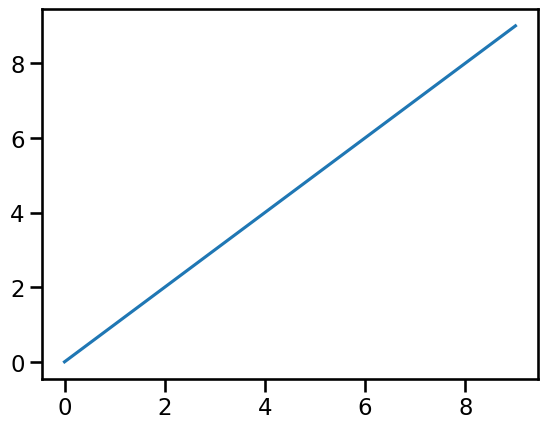

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('pandas1book') 
sns.set_context('talk')
plt.plot(range(10))

<Axes: xlabel='year'>

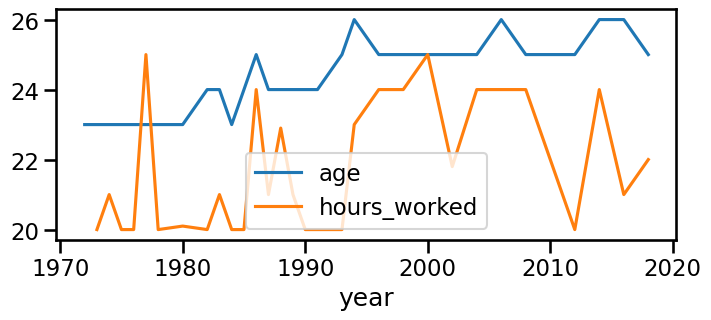

In [85]:
(gss2
   .groupby('year')
   [['age', 'hours_worked']]
   .quantile(.1)
   .plot(figsize=(8,3))
)

In [87]:
(gss2
   .groupby('year')
   [['age', 'hours_worked']]
   #.mean()
   #.median()
   #.std()
   .max()
  # .plot()
)

,age,hours_worked
year,,
1972,89,<NA>
1973,89,89
1974,89,89
1975,89,89
1976,89,89
1977,89,89
1978,89,89
1980,89,89
1982,89,89


In [92]:
# add sex
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   #.mean()
   #.median()
   #.std()
   .max()
   #.plot()
)

/tmp/ipykernel_42811/3879660861.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


age  hours_worked
year sex                      
1972 Female   89          <NA>
     Male     89          <NA>
1973 Female   86            80
     Male     89            89
1974 Female   89            89
...          ...           ...
2014 Male     89            89
2016 Female   89            89
     Male     89            89
2018 Female   89            89
     Male     89            89

[64 rows x 2 columns]

/tmp/ipykernel_42811/3478492041.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


<Axes: xlabel='year,sex'>

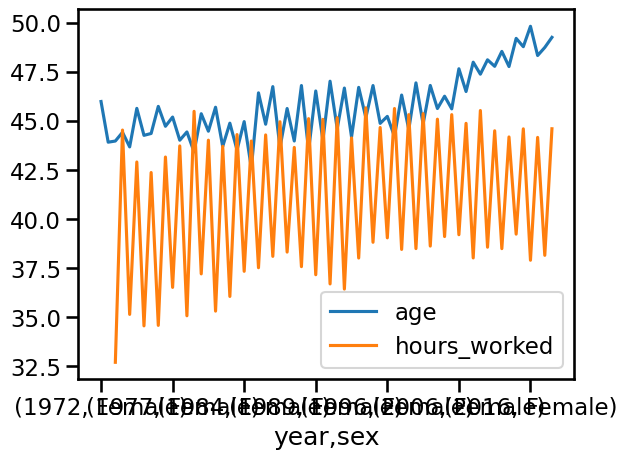

In [95]:
# add sex
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   #.median()
   #.std()
   #.max()
  .plot()
)

/tmp/ipykernel_42811/146850205.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


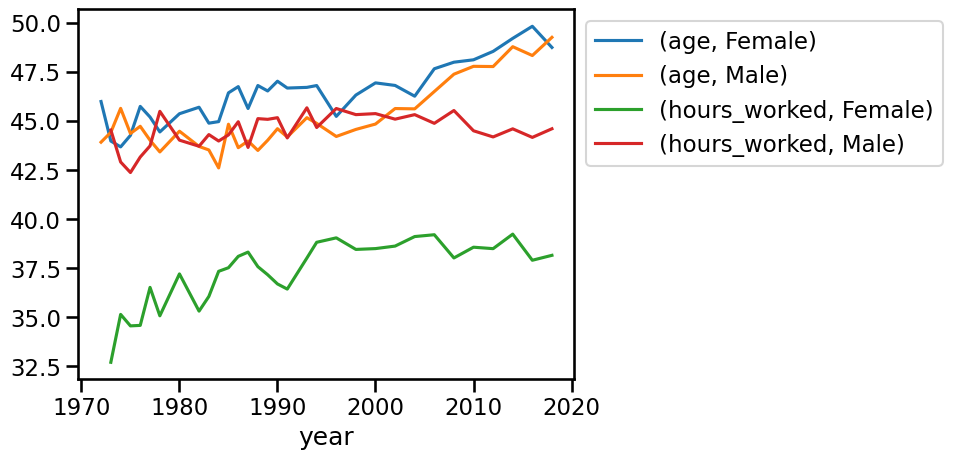

In [105]:
# unstack
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   #.median()
   #.std()
   #.max()
   .unstack() 
   #.stack()
   .plot()
   .legend(bbox_to_anchor=(1,1))
)

/tmp/ipykernel_42811/3989127606.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


<Axes: xlabel='year'>

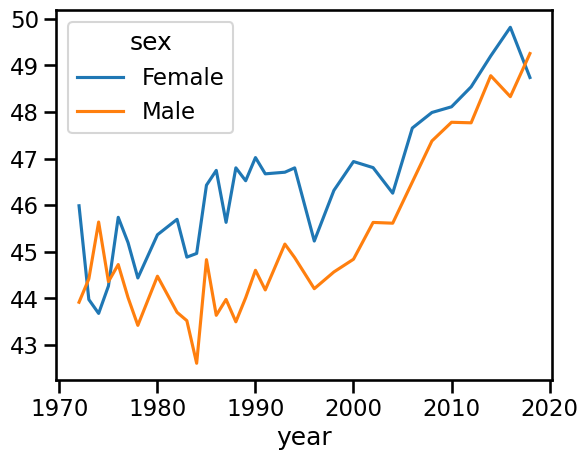

In [112]:
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   .unstack()
   .age
   .plot()
)

/tmp/ipykernel_42811/590450693.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


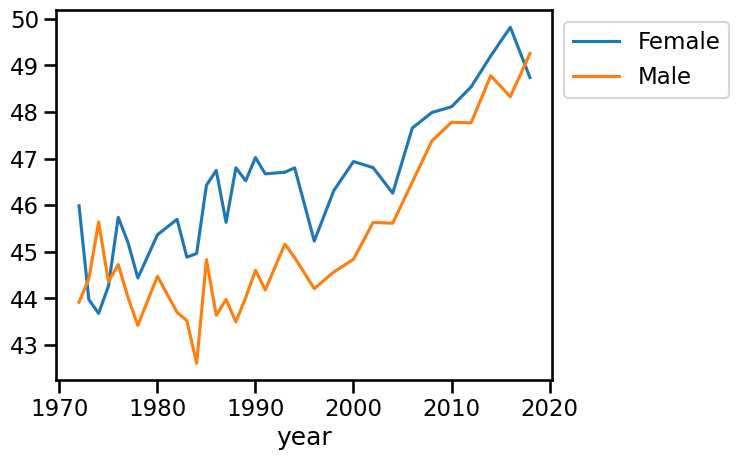

In [113]:
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   .unstack()
   .age
   .plot()
   .legend(bbox_to_anchor=(1,1))
)

/tmp/ipykernel_42811/667451209.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


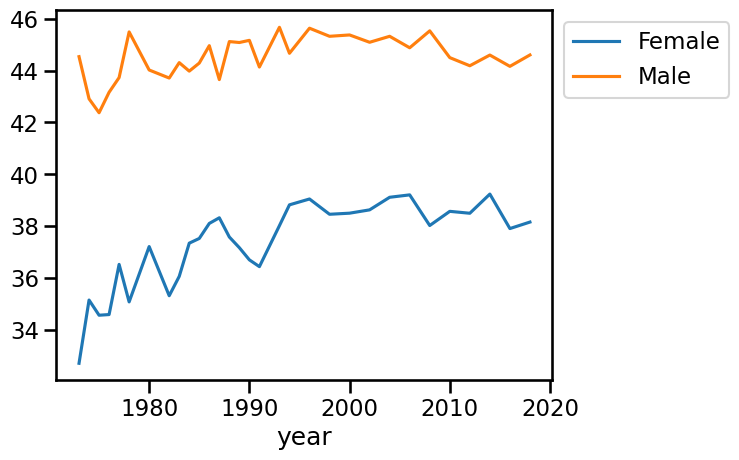

In [114]:
# Let's try looking at hours worked
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   .unstack()
   .hours_worked
   .plot()
   .legend(bbox_to_anchor=(1,1))
)

In [120]:
# Multiple aggregates
def second(group):
    return group.iloc[1]
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
  .agg(['min', 'max', 'mean', second])
#  .reset_index()
#  .stack()
#  .unstack()
#  .unstack()
   
)

/tmp/ipykernel_42811/1737093650.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'sex'])


year     sex age                       hours_worked                   \
                 min max       mean second          min   max       mean   
0   1972  Female  18  89  45.987547     48         <NA>  <NA>       <NA>   
1   1972    Male  18  89  43.916770     26         <NA>  <NA>       <NA>   
2   1973  Female  18  86  43.974969     36            1    80  32.707792   
3   1973    Male  18  89  44.417974     32            0    89  44.534737   
4   1974  Female  18  89  43.676806     69            8    89  35.146259   
..   ...     ...  ..  ..        ...    ...          ...   ...        ...   
59  2014    Male  18  89  48.779438     59            1    89  44.596257   
60  2016  Female  18  89  49.818927     55            1    89  37.903981   
61  2016    Male  18  89  48.329403     61            1    89  44.160354   
62  2018  Female  18  89  48.740712     63            1    89  38.154712   
63  2018    Male  18  89  49.255481     42            1    89       44.6   

           
   second  
0    <NA>  
1    <NA>  
2      40  
3      40  
4    <NA>  
..    ...  
59   <NA>  
60      5  
61     42  
62     40  
63     40  

[64 rows x 10 columns]

## Aggregation Exercise
* Which occupation has the highest median hours worked?
* Which occupation has the lowest age?
* What is the breakdown of respondents by race for each year?  (`.value_counts()`)
* Convert the previous to a percentage.
* How many unique occupations are there for each year?
* What is the most popular college_major for each year?
* What is the second most popular college_major for each year? 

In [9]:
# Which occupation has the highest median hours worked?
(tweak_gss(gss)
    .groupby('occupation')
    .hours_worked
    .median()
    .sort_values(ascending=False)
    )

occupation
712    66.0
580    65.0
65     60.0
760    60.0
802    60.0
       ... 
636    <NA>
661    <NA>
670    <NA>
701    <NA>
763    <NA>
Name: hours_worked, Length: 414, dtype: double[pyarrow]

In [12]:
# Which occupation has the lowest age?
# this one is a little vague, it could be asking for the youngest person in each occupation
# or the median age in each occupation
(tweak_gss(gss)
    .groupby('occupation')
    .age
    
    .median() # 
    # .min()
    .sort_values()
    )

occupation
911    20.0
431    22.0
572    22.0
763    22.0
953    22.0
       ... 
501    72.0
442    75.5
34     77.0
444    82.0
132    89.0
Name: age, Length: 414, dtype: double[pyarrow]

<Axes: xlabel='year'>

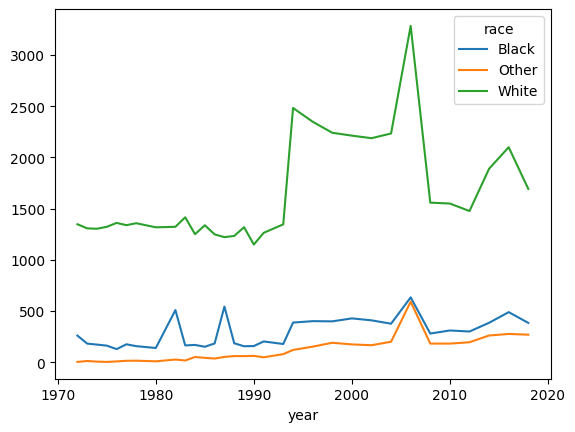

In [18]:
# What is the breakdown of respondents by race for each year?  (`.value_counts()`)
(tweak_gss(gss)
 .groupby('year')
 ['race']
    .value_counts()
    .unstack()
    .plot()
)

<Axes: xlabel='year'>

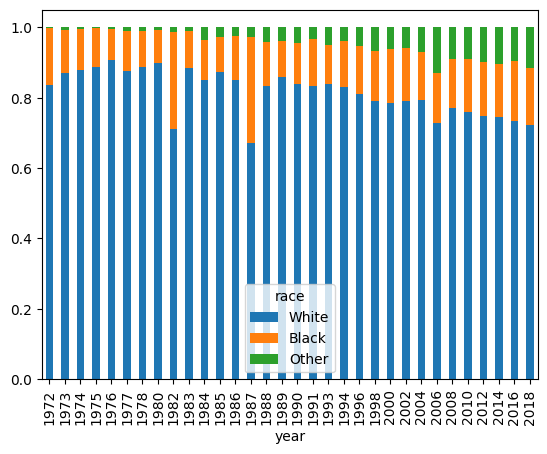

In [24]:
# * Convert the previous to a percentage.
(tweak_gss(gss)
 .groupby('year')
 ['race']
 .value_counts(normalize=True)
 .unstack()
 .loc[:, ['White', 'Black', 'Other']]
 .plot.bar(stacked=True)
)

In [25]:
# How many unique occupations are there for each year?
(tweak_gss(gss)
 .groupby('year')
 ['occupation']
 .nunique()
)

year
1972    259
1973    259
1974    266
1975    248
1976    251
1977    262
1978    250
1980    254
1982    247
1983    262
1984    241
1985    271
1986    267
1987    275
1988    268
1989    275
1990    250
1991      1
1993      1
1994      1
1996      1
1998      1
2000      1
2002      1
2004      1
2006      1
2008      1
2010      1
2012      1
2014      1
2016      1
2018      1
Name: occupation, dtype: int64

In [32]:
# What is the most popular college_major for each year?
(tweak_gss(gss)
 .groupby('year')
 ['college_major']
 .value_counts()
 .groupby('year')
 .head(1)
)

year  college_major
1972  No answer        1613
1973  No answer        1504
1974  No answer        1484
1975  No answer        1490
1976  No answer        1499
1977  No answer        1530
1978  No answer        1532
1980  No answer        1468
1982  No answer        1860
1983  No answer        1599
1984  No answer        1473
1985  No answer        1534
1986  No answer        1470
1987  No answer        1819
1988  No answer        1481
1989  No answer        1537
1990  No answer        1372
1991  No answer        1517
1993  No answer        1606
1994  No answer        2992
1996  No answer        2904
1998  No answer        2832
2000  No answer        2817
2002  No answer        2765
2004  No answer        2812
2006  No answer        4510
2008  No answer        2023
2010  No answer        2044
2012  No answer        1265
2014  No answer        1601
2016  No answer        1800
2018  No answer        1438
Name: count, dtype: int64

In [29]:
# What is the most popular college_major for each year?
(tweak_gss(gss)
 .groupby('year')
 ['college_major']
 .agg(lambda g: g.value_counts().index[0])
)

year
1972    No answer
1973    No answer
1974    No answer
1975    No answer
1976    No answer
1977    No answer
1978    No answer
1980    No answer
1982    No answer
1983    No answer
1984    No answer
1985    No answer
1986    No answer
1987    No answer
1988    No answer
1989    No answer
1990    No answer
1991    No answer
1993    No answer
1994    No answer
1996    No answer
1998    No answer
2000    No answer
2002    No answer
2004    No answer
2006    No answer
2008    No answer
2010    No answer
2012    No answer
2014    No answer
2016    No answer
2018    No answer
Name: college_major, dtype: object

In [30]:
# * What is the second most popular college_major for each year? 
(tweak_gss(gss)
 .groupby('year')
 ['college_major']
 .agg(lambda g: g.value_counts().index[1])
)

year
1972     Accounting/bookkeeping
1973     Accounting/bookkeeping
1974     Accounting/bookkeeping
1975     Accounting/bookkeeping
1976     Accounting/bookkeeping
1977     Accounting/bookkeeping
1978     Accounting/bookkeeping
1980     Accounting/bookkeeping
1982     Accounting/bookkeeping
1983     Accounting/bookkeeping
1984     Accounting/bookkeeping
1985     Accounting/bookkeeping
1986     Accounting/bookkeeping
1987     Accounting/bookkeeping
1988     Accounting/bookkeeping
1989     Accounting/bookkeeping
1990     Accounting/bookkeeping
1991     Accounting/bookkeeping
1993     Accounting/bookkeeping
1994     Accounting/bookkeeping
1996     Accounting/bookkeeping
1998     Accounting/bookkeeping
2000     Accounting/bookkeeping
2002     Accounting/bookkeeping
2004     Accounting/bookkeeping
2006     Accounting/bookkeeping
2008     Accounting/bookkeeping
2010     Accounting/bookkeeping
2012    Business administration
2014    Business administration
2016    Business administration
201

In [15]:
tweak_gss(gss).columns

Index(['year', 'year_id', 'age', 'hours_worked', 'occupation', 'college_major',
       'sex', 'race', 'born_in_US', 'income_1970', 'income_2006',
       'honesty_rank', 'traffic_ticket'],
      dtype='object')

## Summary

* Correct types save space and enable convenient math, string, and date functionality
* Chaining operations will:
   * Make code readable
   * Remove bugs
   * Easier to debug
* Don't mutate (there's no point). Embrace chaining.
* ``.apply`` is slow for math
* Aggregations are powerful. Play with them until they make sense

Follow on Twitter ``@__mharrison__``

Book giveaway!

In [121]:
import random
random.randrange(1,53)

1